In [1]:
import torch
import pytorch_lightning as pl

from models.t2t_vit import t2t_vit_14
from vit_shapley.modules.surrogate import Surrogate
from vit_shapley.CIFAR_10_Dataset import CIFAR_10_Dataset, CIFAR_10_Datamodule

In [2]:
datamodule = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False)
datamodule.setup()
data = next(iter(datamodule.train_dataloader()))

images = data['images']
labels = data['labels']
masks = data['masks']

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
target_model = models.t2t_vit.t2t_vit_14(num_classes=10)

checkpoint = torch.load('../../checkpoint_cifar10_T2t_vit_14/ckpt_0.01_0.0005_92.51.pth')

new_state_dict = OrderedDict()

for k, v in checkpoint.items():
    # strip `module.` prefix
    name = k[7:] if k.startswith('module') else k
    new_state_dict[name] = v

state_dict = new_state_dict

target_model.load_state_dict(state_dict)

In [4]:
surrogate = Surrogate(output_dim=10,
                          target_model=target_model,
                          learning_rate=1e-3,
                          weight_decay=0.0,
                          decay_power='cosine',
                          warmup_steps=2)

CIFAR_10 = CIFAR_10_Datamodule(num_players=196, num_mask_samples=1, paired_mask_samples=False)


adopt performer encoder for tokens-to-token


In [ ]:
trainer = pl.Trainer(max_epochs=50, default_root_dir="./checkpoints_surrogate")# logger=False)
trainer.fit(surrogate, CIFAR_10)

In [8]:
out = surrogate(images=images, masks=masks[:,0])
out.shape

torch.Size([32, 1, 10])

In [8]:
import matplotlib.pyplot as plt
import numpy as np

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.title(classes[label])
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


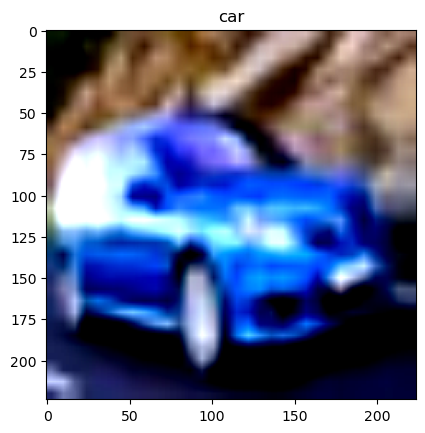

In [10]:
imshow(images[0], labels[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


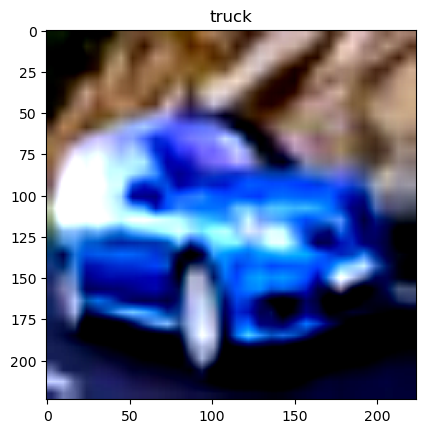

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


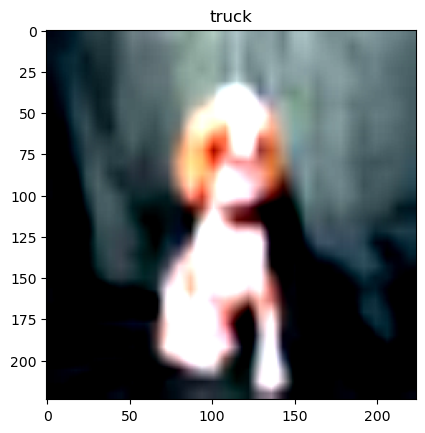

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


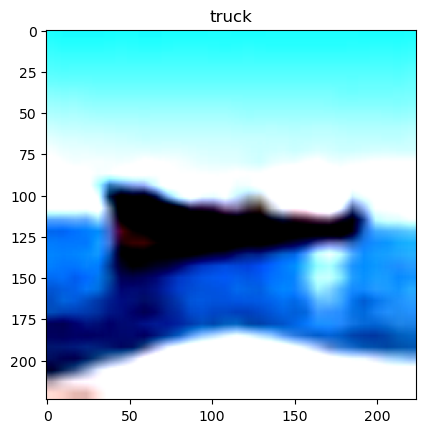

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


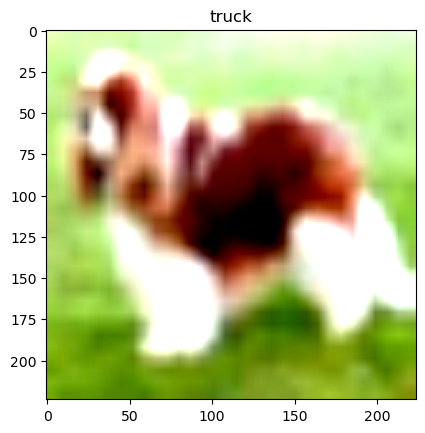

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


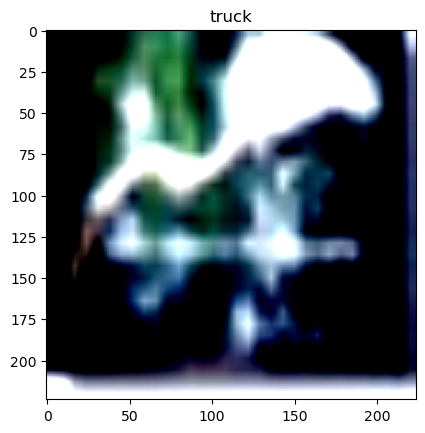

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


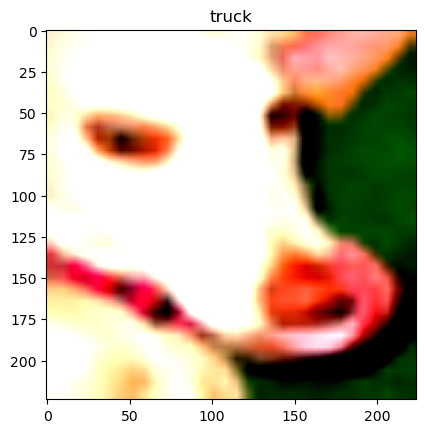

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


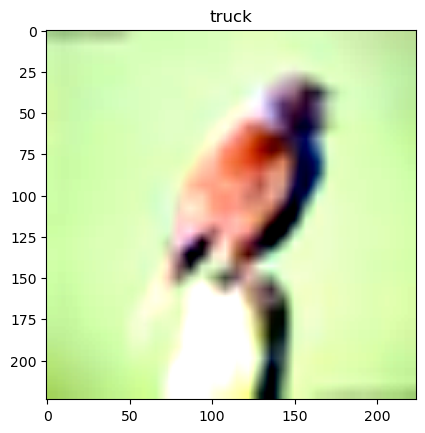

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


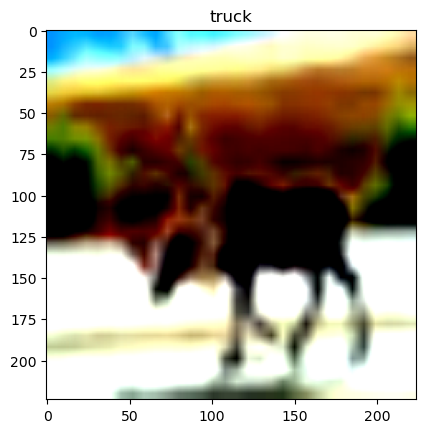

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


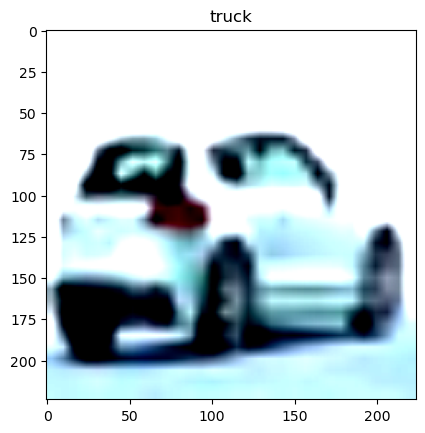

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


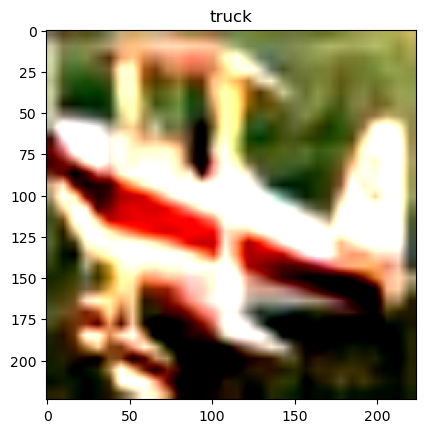

In [13]:
labels_pred = torch.argmax(torch.nn.functional.softmax(out.squeeze(), dim=1), dim=1)
for i in range(10):
    imshow(images[i], labels_pred[i])

In [12]:
labels_pred

tensor([9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
        9, 9, 9, 9, 9, 9, 9, 9])

In [15]:
# surrogate = Surrogate(output_dim=10,
#                           target_model=target_model,
#                           learning_rate=1e-3,
#                           weight_decay=0.0,
#                           decay_power='cosine',
#                           warmup_steps=2)

model = Surrogate.load_from_checkpoint("checkpoints_surrogate/lightning_logs/version_26/checkpoints/epoch=49-step=70350.ckpt",
                                      target_model=target_model,
                                      learning_rate=1e-3,
                                      weight_decay=0.0,
                                      decay_power='cosine',
                                      warmup_steps=2)

# disable randomness, dropout, etc...
model.eval()

# predict with the model
out = surrogate(images=images, masks=masks)

adopt performer encoder for tokens-to-token


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


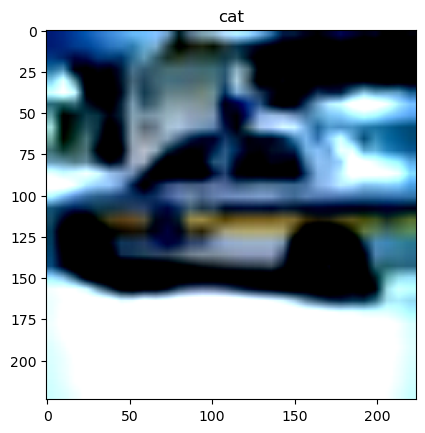

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


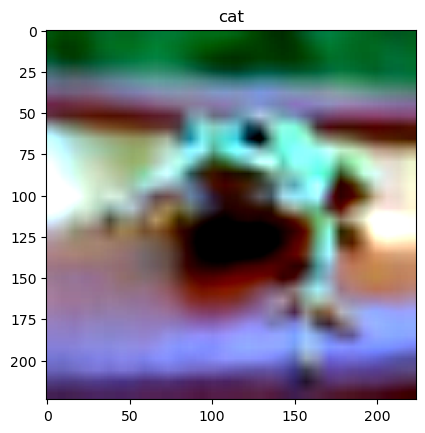

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


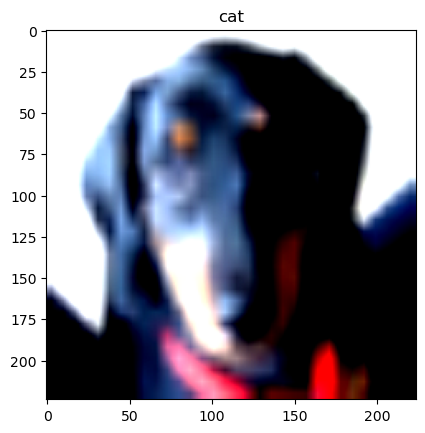

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


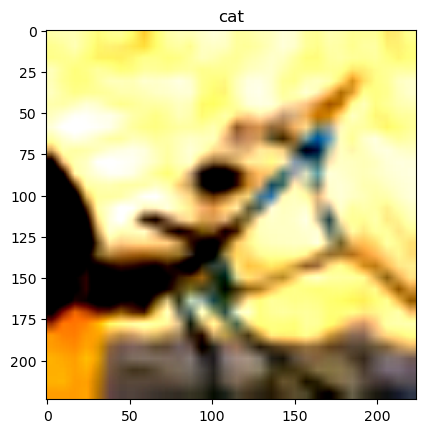

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


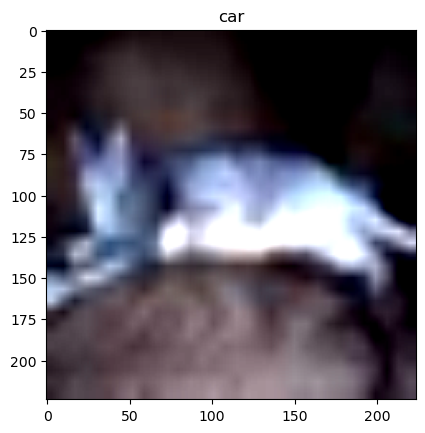

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


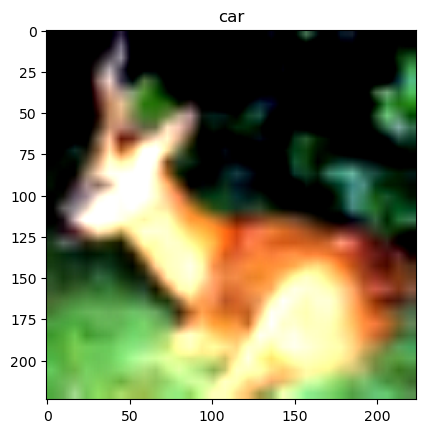

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


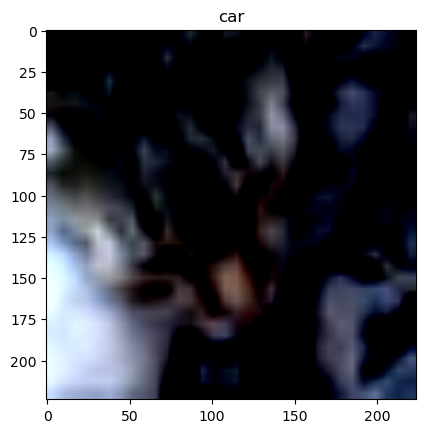

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


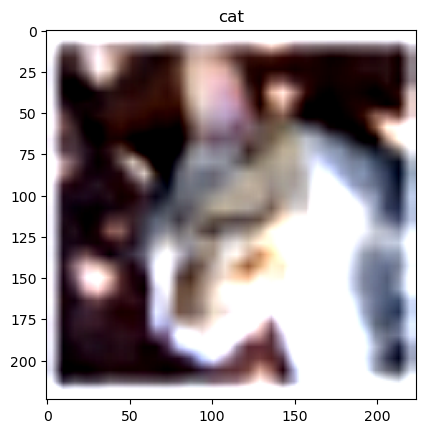

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


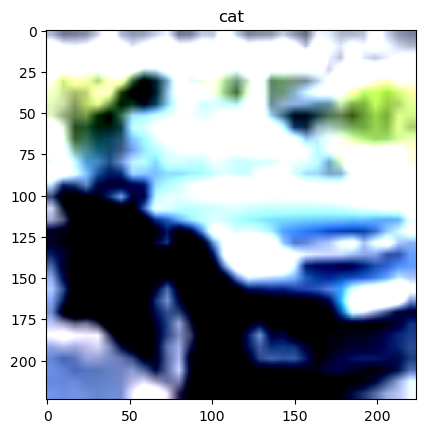

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


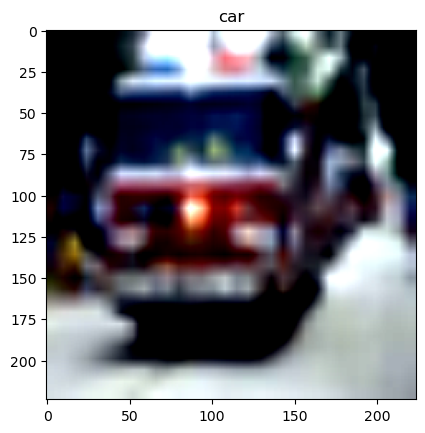

In [18]:
labels_pred = torch.argmax(torch.nn.functional.softmax(out.squeeze(), dim=1), dim=1)
for i in range(10, 20):
    imshow(images[i], labels_pred[i])

In [21]:
labels_pred

tensor([3, 1, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 1, 1, 3, 3, 3,
        3, 3, 3, 3, 1, 1, 1, 3])